In [3]:
# Setting up R dependencies
import anndata2ri
import rpy2
from rpy2.robjects import r
import random


anndata2ri.activate()

%load_ext rpy2.ipython

During startup - Warning message:
Setting LC_CTYPE failed, using "C" 
/tmp/ipykernel_23469/818299201.py:8: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
%%R
library(reticulate)
library(ggplot2)
library(tidyr)
library(dplyr)
library(purrr)
library(tibble)
library(CellChat)
library(patchwork)
library(anndata)
library(Matrix)
library(zellkonverter)
library(future)
options(stringsAsFactors = FALSE)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: igraph

Attaching package: 'igraph'

The following object is masked from 'package:tibble':

    as_data_frame

The following objects are masked from 'package:purrr':

    compose, simplify

The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union

The following object is masked from 'package:tidyr':

    crossing

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'future'

The following objects are masked from 'package:igraph':

    %->%, %<-%



## Cellchat

In [5]:
%%R

# Load the h5ad file
adata <- read_h5ad("/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/adata_nomet.h5ad")

# Extract the log layer data as input
data.input <- t(as.matrix(adata$layers["log"]))

# Extract metadata
meta <- adata$obs


meta$labels <- meta$cell_type 
table(meta$cell_type)
levels(meta$cell_type) <- c(levels(meta$cell_type), "Neutrophil")

# Convert cell_type to character type for modification
meta$cell_type <- as.character(meta$cell_type)
meta$cell_type[meta$cell_type == "N2" | meta$cell_type == "Non_N2"] <- "Neutrophil" # Change "N2" and "Non_N2" to "Neutrophil"

# Update the labels in metadata
meta$labels <- meta$cell_type
table(meta$cell_type)


+ . /share/anaconda3/bin/activate
+ conda activate '/share/anaconda3/envs/scRNApipe'
+ '/share/anaconda3/envs/scRNApipe/bin/python' -m pip install --upgrade --no-user anndata


Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple



          B Cell           CD4+ T           CD8+ T Endothelial Cell 
             294             1121             1076              195 
 Epithelial Cell       Fibroblast       Macrophage        Mast Cell 
            4004              428              296               74 
      Neutrophil      Plasma Cell 
            3219              622 



Done!
In addition: Warning message:
In asMethod(object) :
  sparse->dense coercion: allocating vector of size 3.9 GiB


In [6]:
%%R

# Create cellchat object
cellchat <- createCellChat(object = data.input, meta = meta, group.by = "labels")

# Add metadata and set default cell identity to "labels"
cellchat <- addMeta(cellchat, meta = meta)
cellchat <- setIdent(cellchat, ident.use = "labels")

# Confirm and count the number of cells in each group,
levels(cellchat@idents)
groupSize <- as.numeric(table(cellchat@idents))
print(groupSize)

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  B Cell CD4+ T CD8+ T Endothelial Cell Epithelial Cell Fibroblast Macrophage Mast Cell Neutrophil Plasma Cell 
 [1]  294 1121 1076  195 4004  428  296   74 3219  622


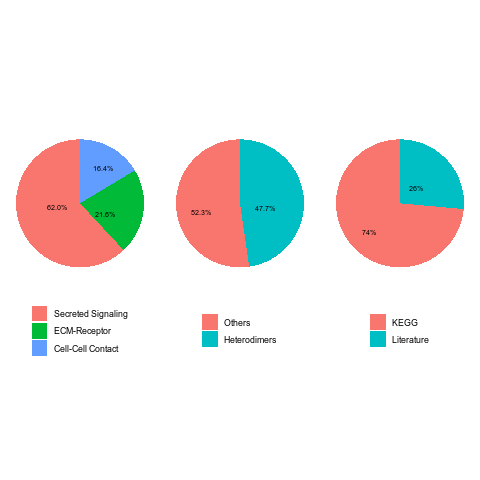

In [7]:
%%R
#Customize CellChatDB
options(stringsAsFactors = FALSE)
interaction_input <- read.csv(file = '/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/CellChatDB/new_interaction_input_CellChatDB.csv', row.names = 1)
complex_input <- read.csv(file = '/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/CellChatDB/complex_input_CellChatDB.csv', row.names = 1)
cofactor_input <- read.csv(file = '/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/CellChatDB/cofactor_input_CellChatDB.csv', row.names = 1)
geneInfo <- read.csv(file = '/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/CellChatDB/geneInfo_input_CellChatDB.csv', row.names = 1)
CellChatDB <- list()
CellChatDB$interaction <- interaction_input
CellChatDB$complex <- complex_input
CellChatDB$cofactor <- cofactor_input
CellChatDB$geneInfo <- geneInfo
showDatabaseCategory(CellChatDB)

In [8]:
%%R
## Confirm STING being added
tail(interaction_input, n = 5)

             interaction_name pathway_name ligand receptor agonist antagonist
DDX41_STING1     DDX41_STING1        STING  DDX41   STING1                   
IFI16_STING1     IFI16_STING1        STING  IFI16   STING1                   
MRE11_STING1     MRE11_STING1        STING  MRE11   STING1                   
PRKDC_STING1     PRKDC_STING1        STING  PRKDC   STING1                   
ZBP1_STING1       ZBP1_STING1        STING   ZBP1   STING1                   
             co_A_receptor co_I_receptor       evidence         annotation
DDX41_STING1                             KEGG: hsa04623 Secreted Signaling
IFI16_STING1                             KEGG: hsa04623 Secreted Signaling
MRE11_STING1                             KEGG: hsa04623 Secreted Signaling
PRKDC_STING1                             KEGG: hsa04623 Secreted Signaling
ZBP1_STING1                              KEGG: hsa04623 Secreted Signaling
             interaction_name_2
DDX41_STING1     DDX41 - STING1
IFI16_STING1     I

In [10]:
%%R
# Subset data
cellchat@DB <- CellChatDB
cellchat <- subsetData(cellchat)

In [11]:
%%R
str(cellchat@data.signaling)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:843077] 4 8 12 14 15 24 35 40 41 61 ...
  ..@ p       : int [1:11330] 0 138 202 221 232 291 330 397 495 540 ...
  ..@ Dim     : int [1:2] 975 11329
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:975] "ACKR1" "ACKR2" "ACKR3" "ACKR4" ...
  .. ..$ : chr [1:11329] "AAACCCAGTCATGACT-1-non_trans_GEO" "AAACCCAGTCCGAAGA-1-non_trans_GEO" "AAACCCAGTCTAGGTT-1-non_trans_GEO" "AAACCCAGTCTCACGG-1-non_trans_GEO" ...
  ..@ x       : num [1:843077] 2.41 1.47 2.67 1.47 2.88 ...
  ..@ factors : list()


In [16]:
%%R
options(future.globals.maxSize = 600 * 1024^2)

future::plan("multisession", workers = 4) # Set up parallel processing with 4 workers

# Record start time
ptm <- Sys.time()

# Identify overexpressed genes
cellchat <- identifyOverExpressedGenes(cellchat)

# Identify overexpressed interactions
cellchat <- identifyOverExpressedInteractions(cellchat)

# Calculate and print execution time in seconds
execution.time <- Sys.time() - ptm
print(as.numeric(execution.time, units = "secs"))


During startup - Warning message:
Setting LC_CTYPE failed, using "C" 
During startup - Warning message:
Setting LC_CTYPE failed, using "C" 
During startup - Warning message:
Setting LC_CTYPE failed, using "C" 
During startup - Warning message:
Setting LC_CTYPE failed, using "C" 


[1] 143.0503


In [15]:
%%R
future::plan("multisession", workers = 4)
ptm = Sys.time()
cellchat <- computeCommunProb(cellchat, type = "triMean")

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-04-06 04:06:37]"


  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-04-06 06:10:14]"


In [16]:
%%R
cellchat <- filterCommunication(cellchat, min.cells = 10)
cellchat <- computeCommunProbPathway(cellchat)

In [17]:
%%R
cellchat <- aggregateNet(cellchat)
#execution.time = Sys.time() - ptm
#print(as.numeric(execution.time, units = "secs"))

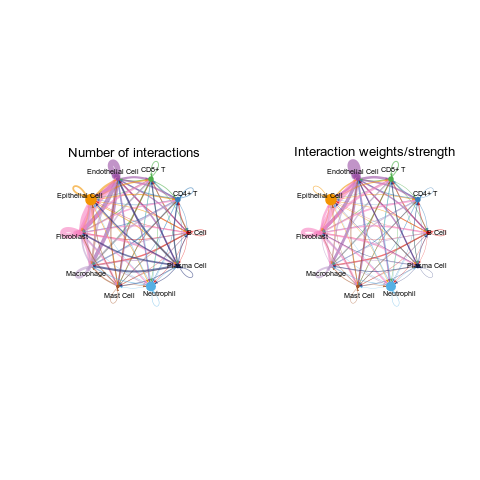

In [18]:
%%R
ptm = Sys.time()
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.label.cex = 0.6, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.label.cex = 0.6, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction strength")

In [22]:
%%R
# Save the plots
svg_filename1 <- "/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/Number_of_interactions_met.svg"
svg_filename2 <- "/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/Interaction_strength_met.svg"

svg(svg_filename1)
netVisual_circle(cellchat@net$count, vertex.label.cex = 0.7, vertex.weight = groupSize, weight.scale = TRUE, label.edge= FALSE, title.name = "Number of interactions")
dev.off()

svg(svg_filename2)
netVisual_circle(cellchat@net$weight, vertex.label.cex = 0.7, vertex.weight = groupSize, weight.scale = TRUE, label.edge= FALSE, title.name = "Interaction strength")
dev.off()

png 
  2 


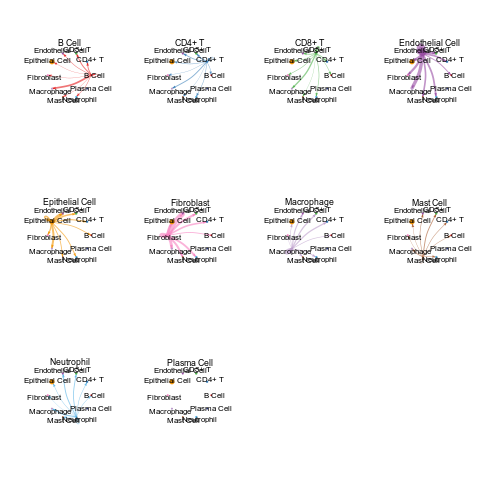

In [35]:
%%R
mat <- cellchat@net$weight
par(mfrow = c(3,4), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}

In [36]:
%%R
# Access all the signaling pathways showing significant communications
pathways.show.all <- cellchat@netP$pathways
# check the order of cell identity to set suitable vertex.receiver
levels(cellchat@idents)
vertex.receiver = seq(1,4)

R[write to console]: Comparing communications on a single object 




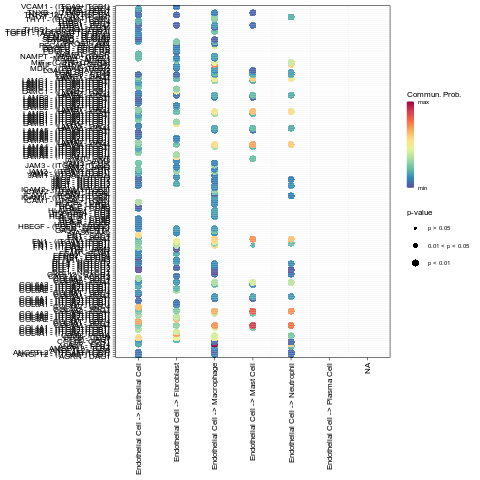

In [37]:
%%R
# show all the significant interactions (L-R pairs) from some cell groups (defined by 'sources.use') to other cell groups (defined by 'targets.use')
netVisual_bubble(cellchat, sources.use = 4, targets.use = c(5:11), remove.isolate = FALSE)

In [38]:
%%R
ptm = Sys.time()
# Compute the network centrality scores
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP") # the slot 'netP' means the inferred intercellular communication network of signaling pathways
# Visualize the computed centrality scores using heatmap, allowing ready identification of major signaling roles of cell groups
#netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, width = 8, height = 2.5, font.size = 10)

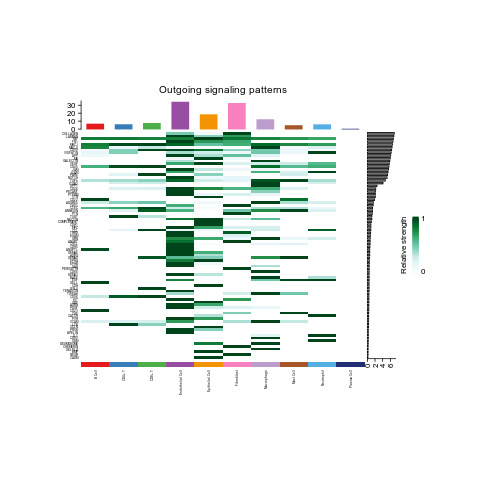

In [39]:
%%R
library(repr)

# Generate signaling role heatmap
options(repr.plot.width=10, repr.plot.height=4)  
ht1 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "outgoing",font.size=3)
print(ht1)  


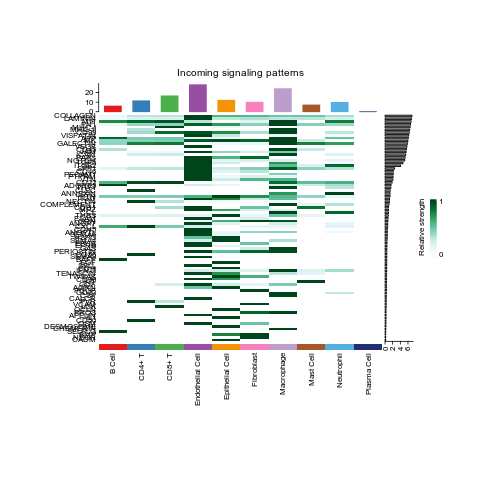

In [40]:
%%R

ht2 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "incoming")
print(ht2)  

In [116]:
%%R

# Save the plots
output_dir <- "/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/"

if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
}
height_value <- 10 

svg(file = paste0(output_dir, "outgoing_group.svg"))
par(mar = c(5, 4, 4, 2) + 0.1)  
ht1 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "outgoing", width =10, height = 10, font.size = 5)
print(ht1)
dev.off()

svg(file = paste0(output_dir, "incoming_group.svg"))
par(mar = c(5, 4, 4, 2) + 0.1)  
ht2 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "incoming", width =10, height = 10, font.size = 5)
print(ht2)
dev.off()

svg(file = paste0(output_dir, "all_group.svg"))
par(mar = c(5, 4, 4, 2) + 0.1)  
ht3 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "all", width =10, height = 10, font.size = 5)
print(ht2)
dev.off()

png 
  2 


In [14]:
%%R
# Load the pathways
pathways_file <- "/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/all_group.csv"
pathways_df <- read_csv(pathways_file)
interested_pathways <- pathways_df[[1]]  # Assuming pathway names are in the first column

# Data cleaning and filtering
interested_pathways <- na.omit(interested_pathways)
interested_interactions <- CellChatDB$interaction %>%
  filter(pathway_name %in% interested_pathways)

# Save the results
output_file <- "/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/interested_interactions.csv"
write_csv(interested_interactions, output_file)


R[write to console]: 
Attaching package: ‘readr’


R[write to console]: The following object is masked from ‘package:anndata’:

    read_csv




New names:
• `` -> `...1`
Rows: 26 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (2): trans, non_trans

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [19]:
%%R

setwd("/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/")
save(cellchat, file = "cellchat_nomet_diy0403.RData")

## Comparison

In [17]:
%%R
data.dir <- '/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/comparison'
dir.create(data.dir)
setwd(data.dir)

In addition: Warning message:
In dir.create(data.dir) :
  '/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/comparison' already exists


In [18]:
%%R

load("/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/cellchat_met_diy0403.RData")
cellchat_met <- cellchat

load("/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/cellchat_nomet_diy0403.RData")
cellchat_nomet <- cellchat

ls() 

 [1] "adata"             "cellchat"          "cellchat_met"     
 [4] "cellchat_nomet"    "CellChatDB"        "cofactor_input"   
 [7] "complex_input"     "data.dir"          "data.input"       
[10] "execution.time"    "geneInfo"          "groupSize"        
[13] "interaction_input" "meta"              "ptm"              


In [19]:
%%R
object.list <- list(`AFPGC LM(-)` = cellchat_nomet, `AFPGC LM(+)` = cellchat_met)

cellchat <- mergeCellChat(object.list, add.names = names(object.list))
cellchat

An object of class CellChat created from a merged object with multiple datasets 
 975 signaling genes.
 21353 cells. 
CellChat analysis of single cell RNA-seq data! 


Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.


In [20]:
%%R

cellchat@DB <- CellChatDB
cellchat <- subsetData(cellchat)

## Total number of interactions and interaction strength


Attaching package: 'gridExtra'

The following object is masked from 'package:Biobase':

    combine

The following object is masked from 'package:BiocGenerics':

    combine

The following object is masked from 'package:dplyr':

    combine



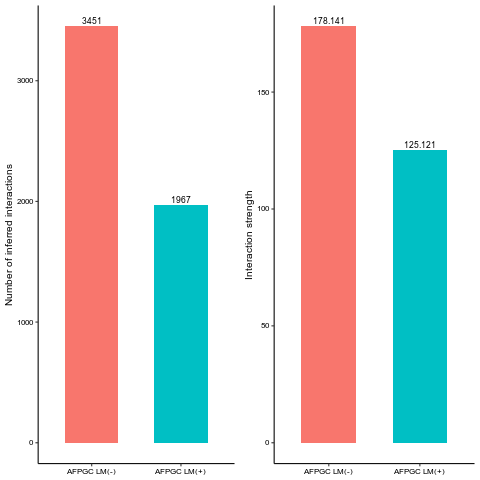

In [21]:
%%R
library(gridExtra)
gg1 <- compareInteractions(cellchat, show.legend = F, group = c(1,2))
gg2 <- compareInteractions(cellchat, show.legend = F, group = c(1,2), measure = "weight")
gg1 + gg2

combined_plot <- grid.arrange(gg1, gg2, ncol=2)


output_file <- "/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/comparison/interaction_comparison_diy.svg"
dir.create(dirname(output_file), recursive = TRUE, showWarnings = FALSE)
ggsave(file = output_file, plot = combined_plot, device = "svg", width = 12, height = 6)

### Difference in the number or strength of interactions between 2 Groups

In [22]:
%%R

output_file_combined <- "/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/comparison/diff_interaction_circle_final.svg"
dir.create(dirname(output_file_combined), recursive = TRUE, showWarnings = FALSE)
svg(filename = output_file_combined, width = 12, height = 6)

# Set up the layout for two plots side by side
par(mfrow = c(1, 2), xpd = TRUE)

# Update cell type to color mapping with new colors
cell_type_colors <- c(
  'B Cell' = '#E3C0BB',
  'CD4+ T' = '#FABFA4',
  'CD8+ T' = '#ABCFC6',
  'Endothelial Cell' = '#FFD594',
  'Epithelial Cell' = '#A8BC8A',
  'Fibroblast' = '#C9A5B7',
  'Macrophage' = '#88A6BB',
  'Mast Cell' = '#747474',
  'Neutrophil' = '#EE9A9F',
  'Plasma Cell' = '#BBC4CA'
)


netVisual_diffInteraction(cellchat, color.use = cell_type_colors, weight.scale = TRUE, vertex.label.cex = 0.8)
netVisual_diffInteraction(cellchat, color.use = cell_type_colors, weight.scale = TRUE, measure = "weight", vertex.label.cex = 0.8)

dev.off()

png 
  2 


Do heatmap based on a merged object 

Do heatmap based on a merged object 



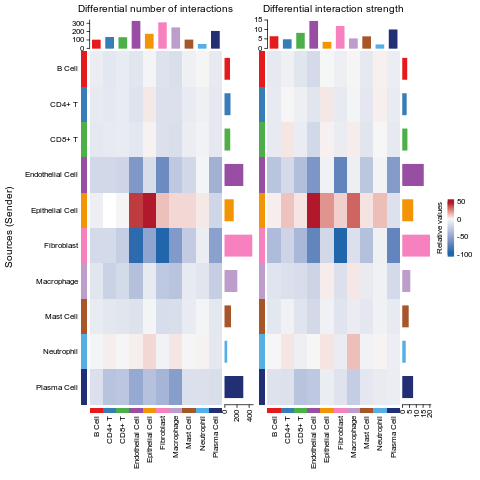

In [23]:
%%R
# Generate the heatmaps
gg1 <- netVisual_heatmap(cellchat)
gg2 <- netVisual_heatmap(cellchat, measure = "weight")

gg1 + gg2

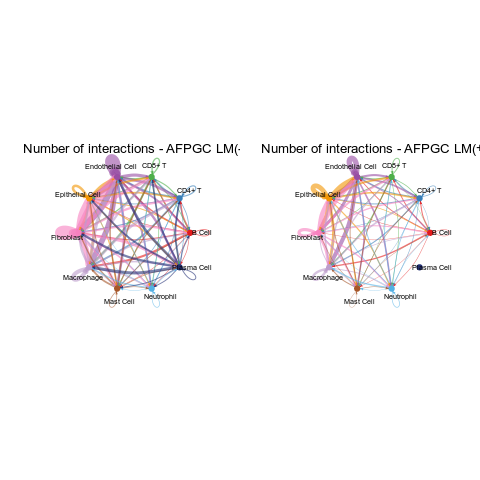

In [24]:
%%R
# Generate the circle plots
weight.max <- getMaxWeight(object.list, attribute = c("idents","count"))
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
  netVisual_circle(object.list[[i]]@net$count, weight.scale = T, label.edge= F, edge.weight.max = weight.max[2], edge.width.max = 12, vertex.label.cex = 0.6,title.name = paste0("Number of interactions - ", names(object.list)[i]))
}

### Compare the overall information flow of each signaling pathway

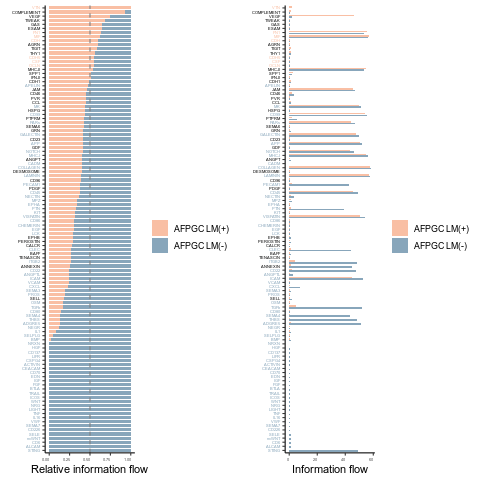

In [25]:
%%R
library(gridExtra)

group_colors <- c('AFPGC LM(+)' = '#f9bfa4', 'AFPGC LM(-)' = '#88a6bb')

# Generate all signaling pathways
data_gg1 <- rankNet(cellchat, mode = "comparison", comparison = c(2, 1), color.use = group_colors, stacked = TRUE, do.stat = TRUE, font.size = 4, return.data = TRUE)
data_gg2 <- rankNet(cellchat, mode = "comparison", comparison = c(2, 1), color.use = group_colors, stacked = FALSE, do.stat = TRUE, font.size = 4, return.data = TRUE)

# Retrieve plot objects
gg1 <- data_gg1$gg.obj
gg2 <- data_gg2$gg.obj

# Plot the figures side-by-side
combined_gg <- grid.arrange(gg1, gg2, ncol = 2)

# Save the plot and data
output_path <- "/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/comparison/detailed_pathway_diff_final.svg"
ggsave(file = output_path, plot = combined_gg, device = "svg", width = 10, height = 5)

# Save signaling contribution data if available
if (!is.null(data_gg1$signaling.contribution)) {
  write.csv(data_gg1$signaling.contribution, "/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/comparison/detailed_pathway_diff_diy.csv", row.names = FALSE)
}


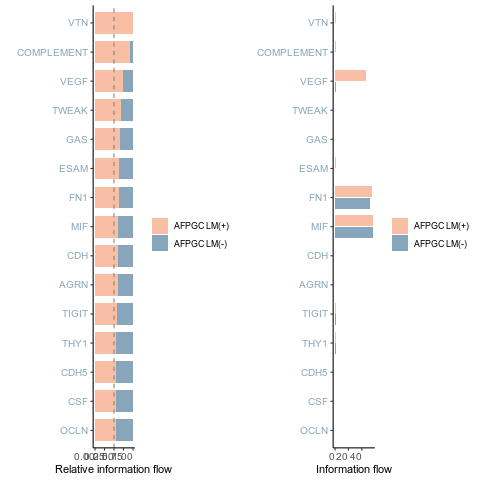

In [26]:
%%R
library(gridExtra)

# Customize signaling pathways
selected_signaling <- c("OCLN", "CSF", "CDH5", "THY1", "TIGIT", "AGRN", "CDH", 
                        "MIF", "FN1", "ESAM", "GAS", "TWEAK", "VEGF", 
                        "COMPLEMENT", "VTN")
# Generate rankNet plots and return data
data_gg1 <- rankNet(cellchat, mode = "comparison", comparison = c(2, 1), color.use = group_colors, stacked = TRUE, do.stat = TRUE, font.size = 10, return.data = TRUE, signaling = selected_signaling)
data_gg2 <- rankNet(cellchat, mode = "comparison", comparison = c(2, 1), color.use = group_colors, stacked = FALSE, do.stat = TRUE, font.size = 10, return.data = TRUE, signaling = selected_signaling)

# Retrieve plot objects
gg1 <- data_gg1$gg.obj
gg2 <- data_gg2$gg.obj

# Plot the figures side-by-side
combined_gg <- grid.arrange(gg1, gg2, ncol = 2)

# Save the plot and data
output_path <- "/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/comparison/detailed_pathway_diff_15.svg"
ggsave(file = output_path, plot = combined_gg, device = "svg", width = 10, height = 5)

# Save signaling contribution data
if (!is.null(data_gg1$signaling.contribution)) {
  write.csv(data_gg1$signaling.contribution, "/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/comparison/detailed_pathway_diff_15.csv", row.names = FALSE)
}


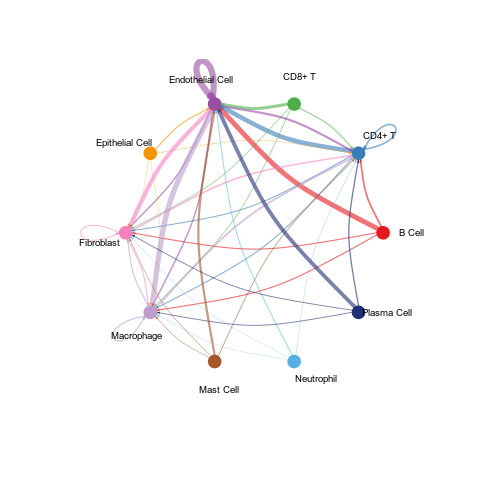

In [38]:
%%R
# Specific signaling pathway
pathways.show <- c("STING") 
# Hierarchy plot
# Here we define `vertex.receive` so that the left portion of the hierarchy plot shows signaling to fibroblast and the right portion shows signaling to immune cells 
vertex.receiver = seq(1,4) # a numeric vector. 
netVisual_aggregate(cellchat_nomet, signaling = pathways.show,  vertex.receiver = vertex.receiver)
# Circle plot
par(mfrow=c(1,1))
netVisual_aggregate(cellchat_nomet, signaling = pathways.show, layout = "circle")

In [71]:
%%R

setwd("/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/comparison")
save(cellchat, file = "cellchat_comparison_diy.RData")

## Diy CellChatDB

In [3]:
%%R
library(CellChat)
options(stringsAsFactors = FALSE)

In [4]:
%%R

base_path <- "/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/CellChatDB"
if (!dir.exists(base_path)) {
  dir.create(base_path, recursive = TRUE)
}

# Set CellChat database to the human dataset
CellChatDB <- CellChatDB.human

# Extract data components
interaction_input <- CellChatDB$interaction
complex_input <- CellChatDB$complex
cofactor_input <- CellChatDB$cofactor
geneInfo <- CellChatDB$geneInfo

# Save data components to CSV files
write.csv(interaction_input, file = paste0(base_path, "/interaction_input_CellChatDB.csv"))
write.csv(complex_input, file = paste0(base_path, "/complex_input_CellChatDB.csv"))
write.csv(cofactor_input, file = paste0(base_path, "/cofactor_input_CellChatDB.csv"))
write.csv(geneInfo, file = paste0(base_path, "/geneInfo_input_CellChatDB.csv"))


In [7]:
%%R

CellChatDB <- CellChatDB.human
options(stringsAsFactors = FALSE)
# Input the new DB modified
interaction_input <- read.csv(file = '/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/CellChatDB/new_interaction_input_CellChatDB.csv', row.names = 1)
complex_input <- read.csv(file = '/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/CellChatDB/complex_input_CellChatDB.csv', row.names = 1)
cofactor_input <- read.csv(file = '/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/CellChatDB/cofactor_input_CellChatDB.csv', row.names = 1)
geneInfo <- read.csv(file = '/share/home/biopharm/wqr/AFPGC/sc/Results/0122/communication/CellChatDB/geneInfo_input_CellChatDB.csv', row.names = 1)
CellChatDB <- list()
CellChatDB$interaction <- interaction_input
CellChatDB$complex <- complex_input
CellChatDB$cofactor <- cofactor_input
CellChatDB$geneInfo <- geneInfo